## Import required libraries

In [1]:
import argparse
from typing import Dict

import numpy as np
from sklearn.model_selection import train_test_split

import xgboost as xgb

## Define the function that will have to be approximated through log. reg.

In [2]:
def f(x: np.ndarray) -> np.ndarray:
    """The function to predict."""
    return np.sin(x) * x

In [8]:
"""Train a quantile regression model."""
rng = np.random.RandomState(1994)
# Generate a synthetic dataset for demo, the generate process is from the sklearn
# example.
X = np.atleast_2d(rng.uniform(0, 20.0, size=100000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 20.0
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2.0 / 2.0)
y = expected_y + noise

# Train on 0.05 and 0.95 quantiles. The model is similar to multi-class and
# multi-target models.
alpha = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
evals_result: Dict[str, Dict] = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, test_size=0.1)
# We will be using the `hist` tree method, quantile DMatrix can be used to preserve
# memory (which has nothing to do with quantile regression itself, see its document
# for details).
# Do not use the `exact` tree method for quantile regression, otherwise the
# performance might drop.
Xy = xgb.QuantileDMatrix(X_train, y_train)
# use Xy as a reference
Xy_test = xgb.QuantileDMatrix(X_test, y_test, ref=Xy)

booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 15,
    },
    Xy,
    num_boost_round=32,
    early_stopping_rounds=2,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)
xx = np.atleast_2d(np.linspace(0, 20, 100000)).T
scores = booster.inplace_predict(xx)
# dim 1 is the quantiles
assert scores.shape[0] == xx.shape[0]
assert scores.shape[1] == alpha.shape[0]

y_lower = scores[:, 0]  # alpha=0.05
y_med = scores[:, 1]  # alpha=0.5, median
y_upper = scores[:, 2]  # alpha=0.95

# Train a mse model for comparison
booster = xgb.train(
    {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 15,
    },
    Xy,
    num_boost_round=32,
    early_stopping_rounds=2,
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)
xx = np.atleast_2d(np.linspace(0, 20, 100000)).T
y_pred = booster.inplace_predict(xx)

[0]	Train-quantile:3.08908	Test-quantile:3.07474
[1]	Train-quantile:2.93922	Test-quantile:2.92578
[2]	Train-quantile:2.79756	Test-quantile:2.78490
[3]	Train-quantile:2.66282	Test-quantile:2.65083
[4]	Train-quantile:2.53510	Test-quantile:2.52373
[5]	Train-quantile:2.41469	Test-quantile:2.40378
[6]	Train-quantile:2.30022	Test-quantile:2.28978
[7]	Train-quantile:2.19234	Test-quantile:2.18243
[8]	Train-quantile:2.09079	Test-quantile:2.08154
[9]	Train-quantile:1.99445	Test-quantile:1.98568
[10]	Train-quantile:1.90348	Test-quantile:1.89511
[11]	Train-quantile:1.81761	Test-quantile:1.80957
[12]	Train-quantile:1.73626	Test-quantile:1.72850
[13]	Train-quantile:1.65960	Test-quantile:1.65208
[14]	Train-quantile:1.58729	Test-quantile:1.57993
[15]	Train-quantile:1.51885	Test-quantile:1.51154
[16]	Train-quantile:1.45430	Test-quantile:1.44693
[17]	Train-quantile:1.39345	Test-quantile:1.38610
[18]	Train-quantile:1.33584	Test-quantile:1.32869
[19]	Train-quantile:1.28151	Test-quantile:1.27455
[20]	Train

## Plot the results

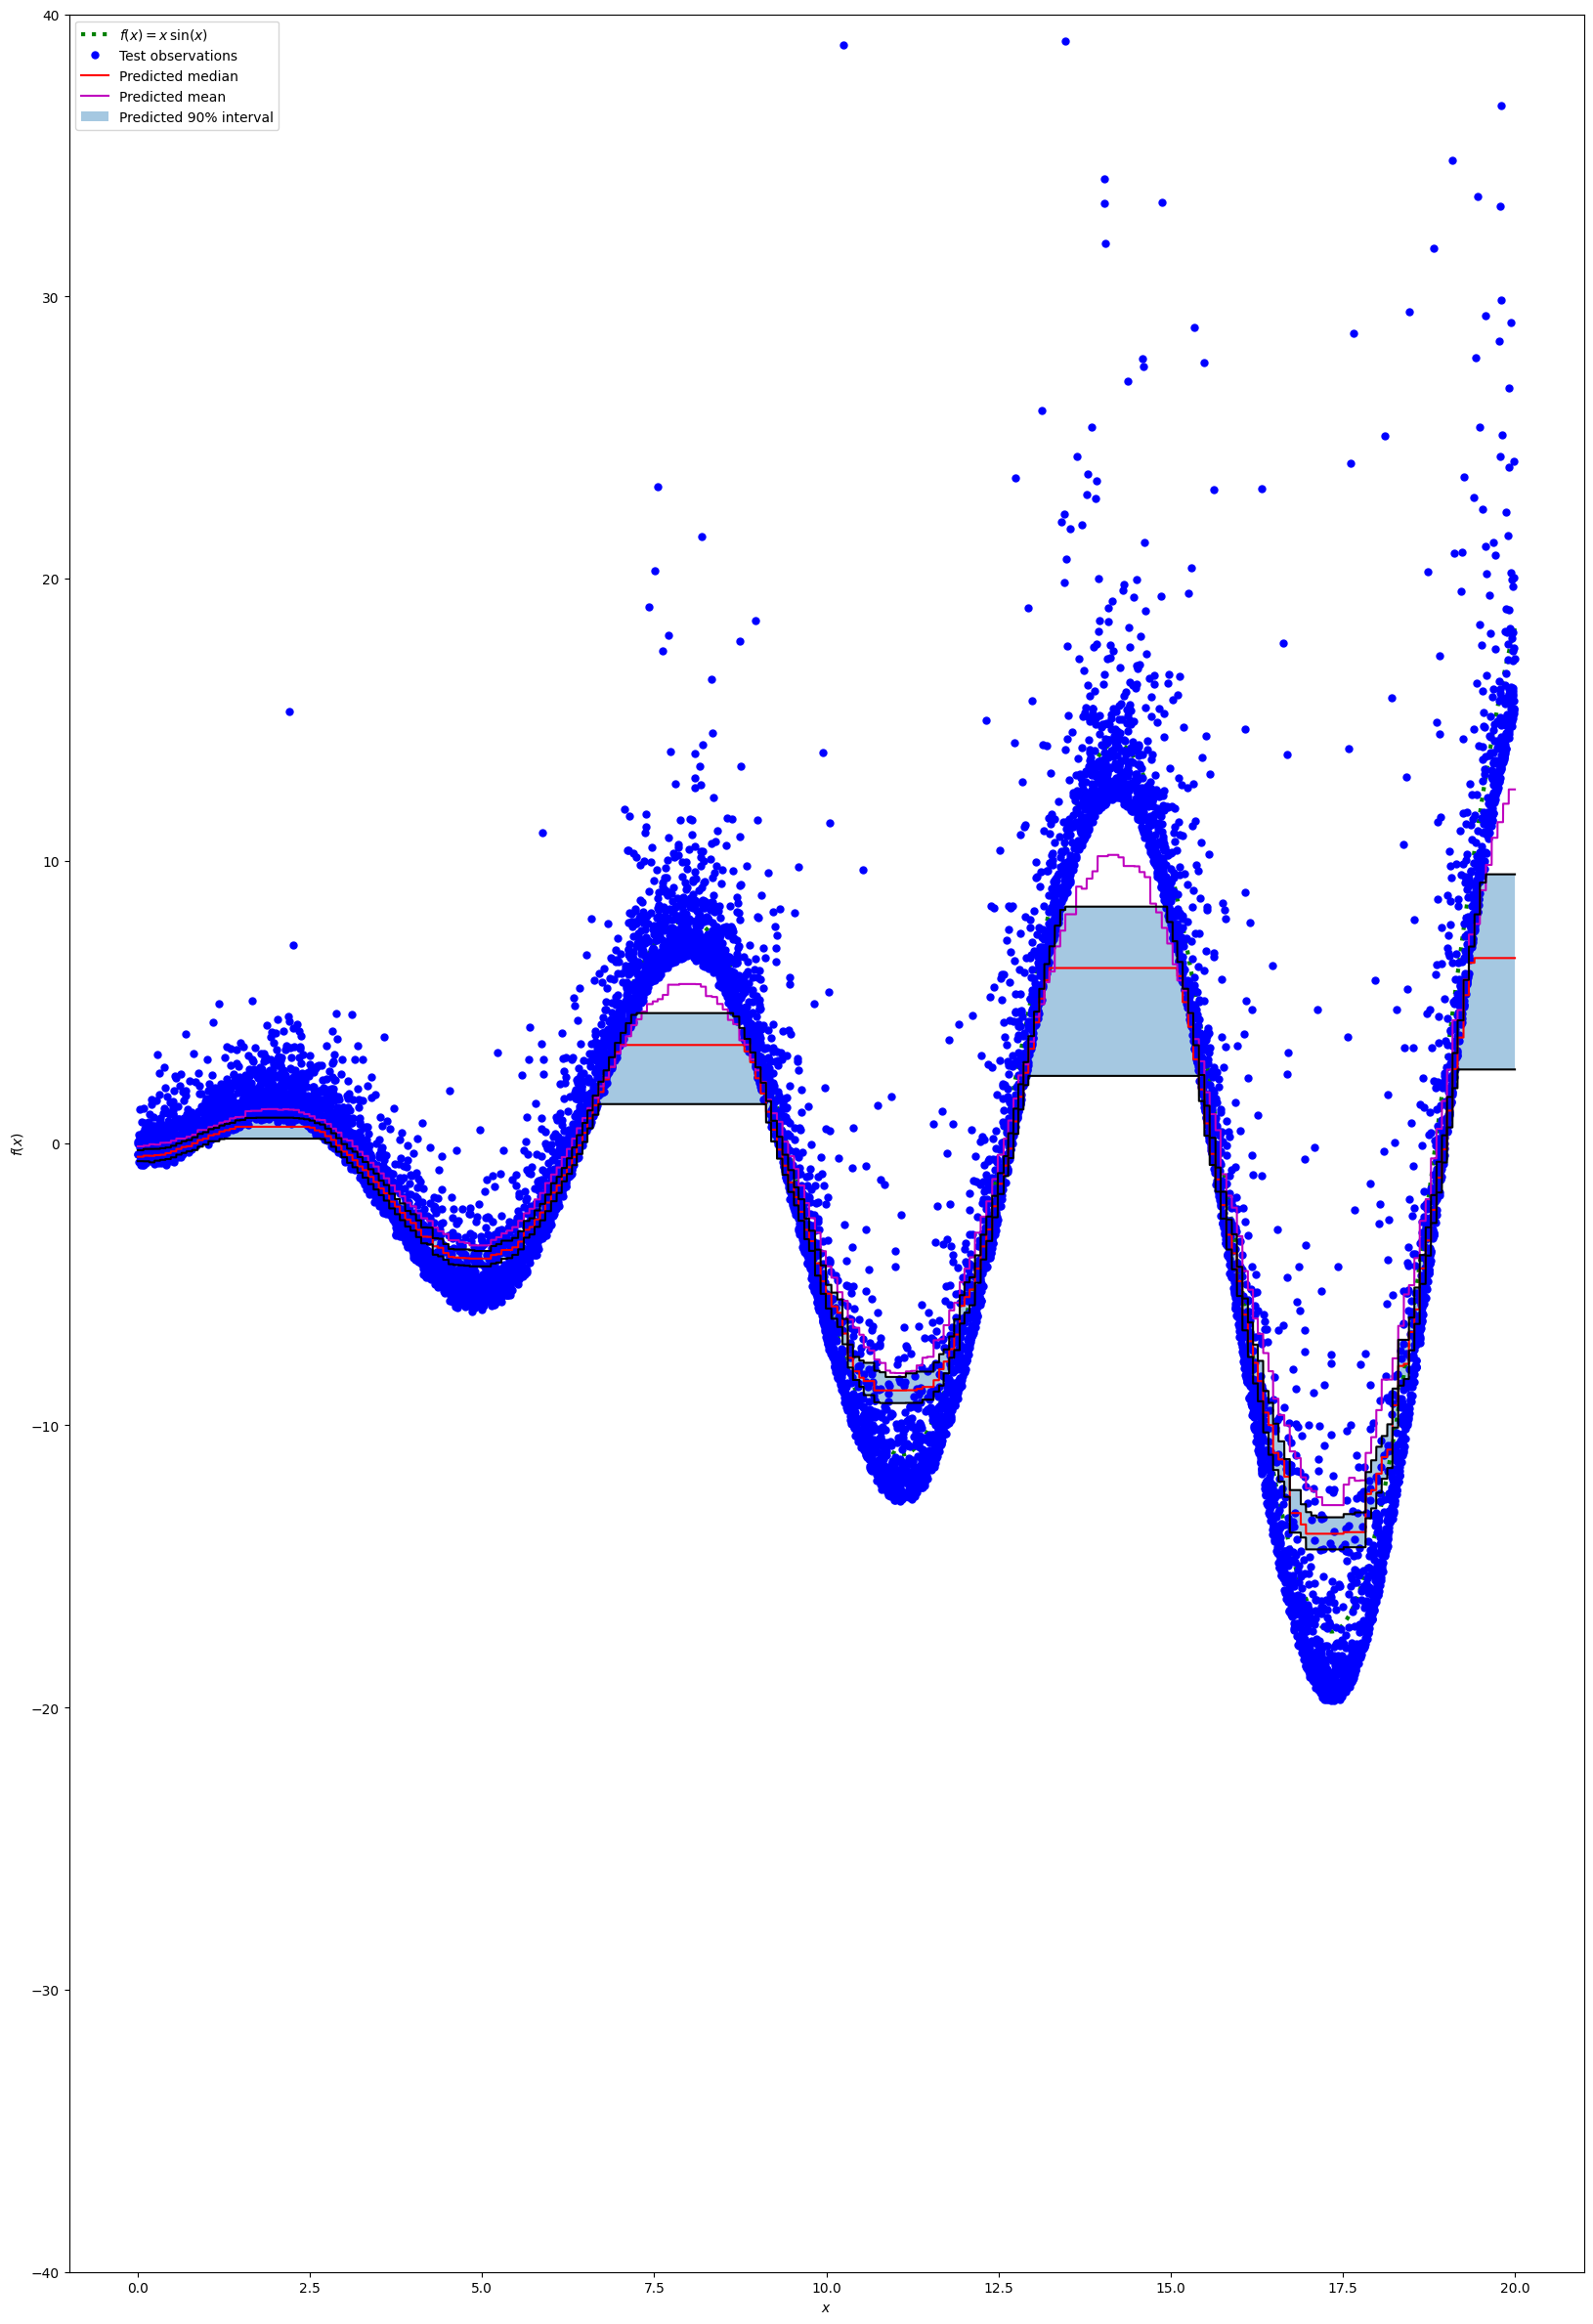

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 30))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "m-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-40, 40)
plt.legend(loc="upper left")
plt.show()